In [1]:
# Calculating 2d ring-resonator modes, from the Meep tutorial.
from __future__ import division

import meep as mp
import matplotlib.pyplot as plt
import numpy as np

n = 3.4                 # index of waveguide
w = 1                   # width of waveguide
r = 1                   # inner radius of ring
pad = 4                 # padding between waveguide and edge of PML
dpml = 2                # thickness of PML
sxy = 2*(r+w+pad+dpml)  # cell size

# Create a ring waveguide by two overlapping cylinders - later objects
# take precedence over earlier objects, so we put the outer cylinder first.
# and the inner (air) cylinder second.

c1 = mp.Cylinder(radius=r+w, material=mp.Medium(index=n))
c2 = mp.Cylinder(radius=r)

# If we don't want to excite a specific mode symmetry, we can just
# put a single point source at some arbitrary place, pointing in some
# arbitrary direction.  We will only look for Ez-polarized modes.

fcen = 0.15             # pulse center frequency
df = 0.1                # pulse width (in frequency)

src = mp.Source(mp.GaussianSource(fcen, fwidth=df), mp.Ez, mp.Vector3(r+0.1))

sim = mp.Simulation(cell_size=mp.Vector3(sxy, sxy),
                    geometry=[c1, c2],
                    sources=[src],
                    resolution=10,
                    symmetries=[mp.Mirror(mp.Y)],
                    boundary_layers=[mp.PML(dpml)])

sim.run(mp.after_sources(mp.Harminv(mp.Ez, mp.Vector3(r+0.1), fcen, df)),
        until_after_sources=300)

-----------
Initializing structure...
harminv0:, frequency, imag. freq., Q, |amp|, amplitude, error
harminv0:, 0.11810185129553134, -0.0007330874412686425, 80.5509988625303, 0.003417786248750663, -0.0030533289564192924-0.0015357229978223957i, 9.77260496303525e-06+0.0i
harminv0:, 0.14716356335877614, -0.00023248964197374852, 316.4948814695862, 0.02864176522660572, 0.019289975126395558-0.021171858088487212i, 7.25420703275517e-07+0.0i
harminv0:, 0.17524701612253343, -5.1901317152922885e-05, 1688.2713747531952, 0.007209193208740666, -0.0008108062040146232-0.007163453079380358i, 1.1777948793010726e-07+0.0i
run 0 finished at t = 400.0 (8000 timesteps)


(-0.5, 159.5, 159.5, -0.5)

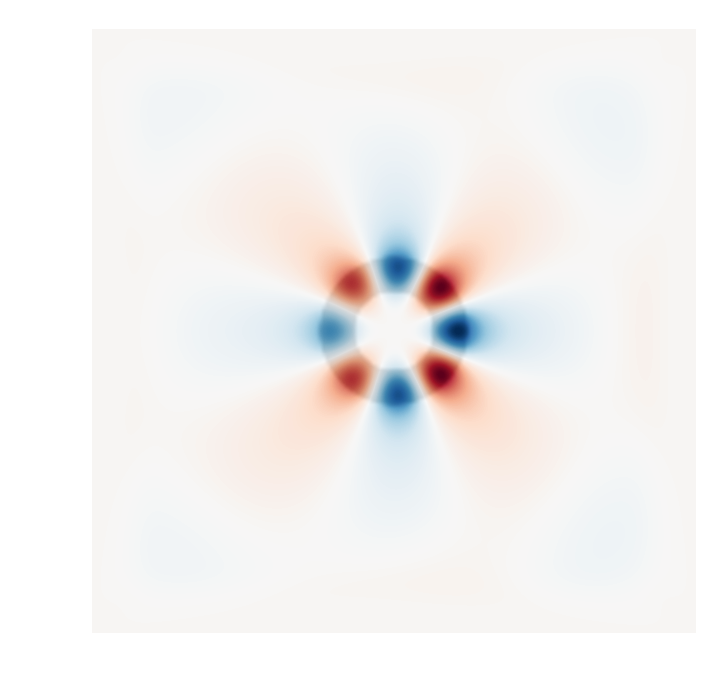

In [2]:
eps_data = sim.get_epsilon()
ez_data = sim.get_efield_z()

plt.figure(dpi=200)
plt.imshow(np.transpose(eps_data), interpolation='spline36', cmap='binary')
plt.imshow(np.transpose(np.real(ez_data)), interpolation='spline36', cmap='RdBu', alpha=0.9)
plt.axis('off')